# Optimización del Modelo: Rebalanceo + Tuning

Este notebook explora cómo mejorar el rendimiento del modelo de clasificación de ictus combinando técnicas de rebalanceo de clases, algoritmos de aprendizaje automático y métodos de optimización de hiperparámetros.

In [1]:
# Carga del dataset preprocesado
import pandas as pd

# Suponemos que el archivo está en la misma carpeta que este notebook
df = pd.read_csv('brain_s.csv')

# Visualizamos las primeras filas
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


## 1. Preparación de datos
Importamos los datos ya preprocesados y realizamos la partición `train/test` (sin rebalanceo aún).

In [2]:
# Carga del dataset limpio y preprocesado
import pandas as pd
from sklearn.model_selection import train_test_split

# Definimos features y target
X = df.drop("stroke", axis=1)
y = df["stroke"]


# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 2. Aplicación de técnicas de rebalanceo
Probamos varias técnicas (SMOTE, RandomUnderSampler, SMOTEENN...) y analizamos cómo afectan a la distribución de clases.

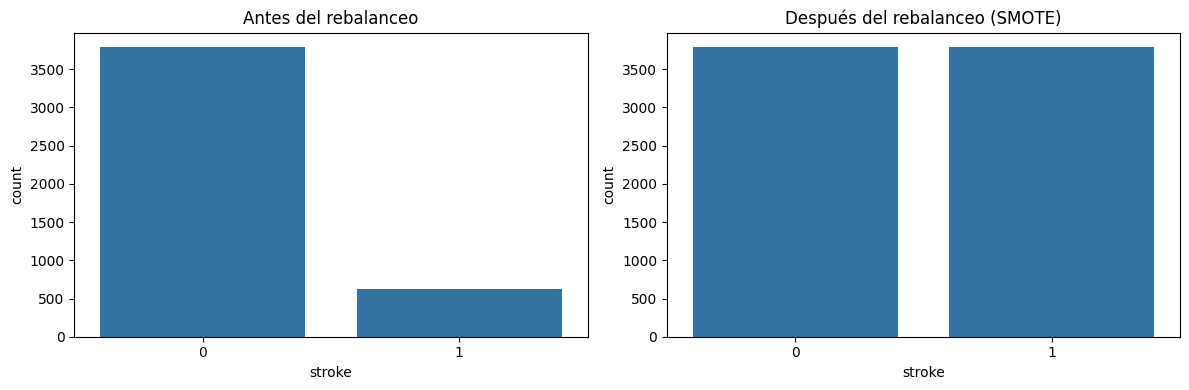

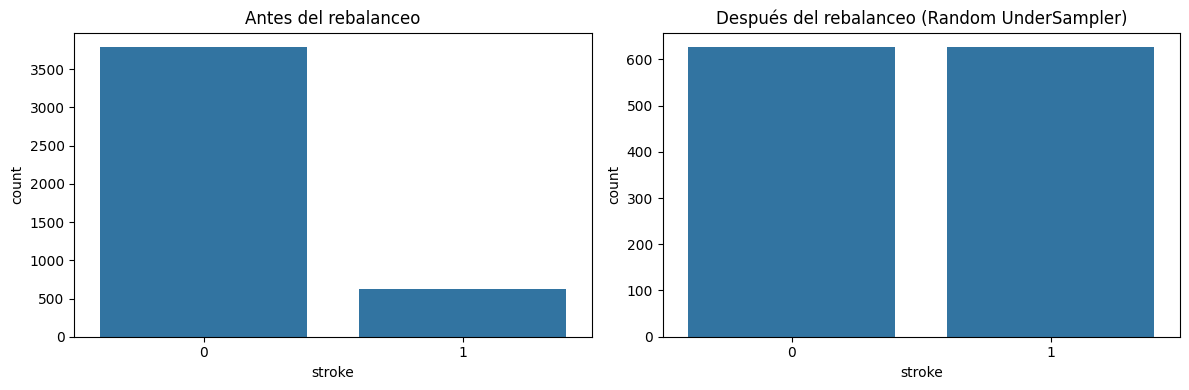

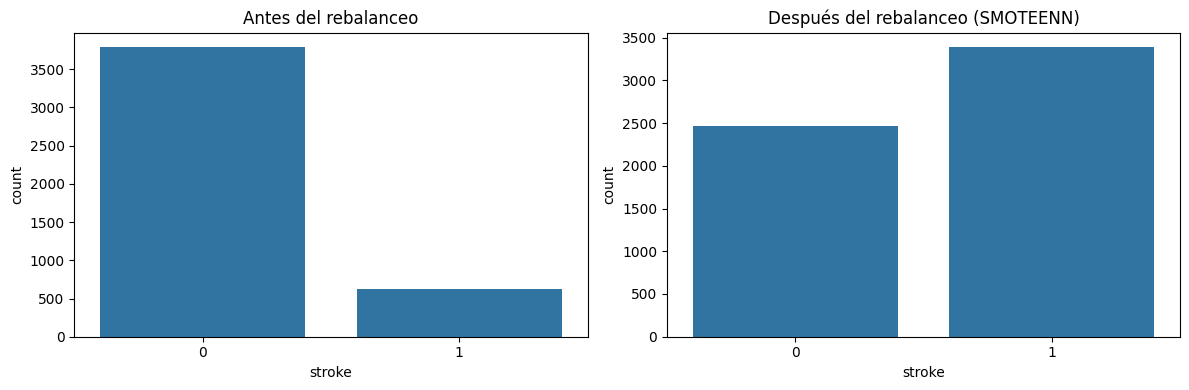

In [3]:
# Aplicación de técnicas de rebalanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns

# Función para mostrar la distribución de clases
def plot_class_distribution(y_original, y_resampled, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x=y_original, ax=ax[0])
    ax[0].set_title('Antes del rebalanceo')
    sns.countplot(x=y_resampled, ax=ax[1])
    ax[1].set_title(f'Después del rebalanceo ({title})')
    plt.tight_layout()
    plt.show()

# SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_smote, 'SMOTE')

# RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_rus, 'Random UnderSampler')

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
plot_class_distribution(y_train, y_smoteenn, 'SMOTEENN')

In [4]:
# Comparación de RandomForest con diferentes técnicas de rebalanceo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Función para evaluar el modelo
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Entrenamiento con SMOTE
print("--- RandomForest con SMOTE ---")
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_smote, y_smote)
evaluate_model(rf_smote, X_test, y_test)

# Entrenamiento con RandomUnderSampler
print("\n--- RandomForest con RandomUnderSampler ---")
rf_rus = RandomForestClassifier(random_state=42)
rf_rus.fit(X_rus, y_rus)
evaluate_model(rf_rus, X_test, y_test)

# Entrenamiento con SMOTEENN
print("\n--- RandomForest con SMOTEENN ---")
rf_smoteenn = RandomForestClassifier(random_state=42)
rf_smoteenn.fit(X_smoteenn, y_smoteenn)
evaluate_model(rf_smoteenn, X_test, y_test)

--- RandomForest con SMOTE ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       947
           1       0.46      0.36      0.40       157

    accuracy                           0.85      1104
   macro avg       0.68      0.65      0.66      1104
weighted avg       0.84      0.85      0.84      1104

ROC AUC: 0.8462

--- RandomForest con RandomUnderSampler ---
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.83      0.50       157

    accuracy                           0.77      1104
   macro avg       0.66      0.79      0.67      1104
weighted avg       0.88      0.77      0.80      1104

ROC AUC: 0.8511

--- RandomForest con SMOTEENN ---
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       947
           1       0.38      0.75      0.50       157

    accuracy                           

## 3. Comparación básica de modelos con diferentes rebalanceos
Entrenamos modelos base (`RandomForest`, `XGBoost`, `LGBM`) con cada técnica y comparamos sus métricas principales.

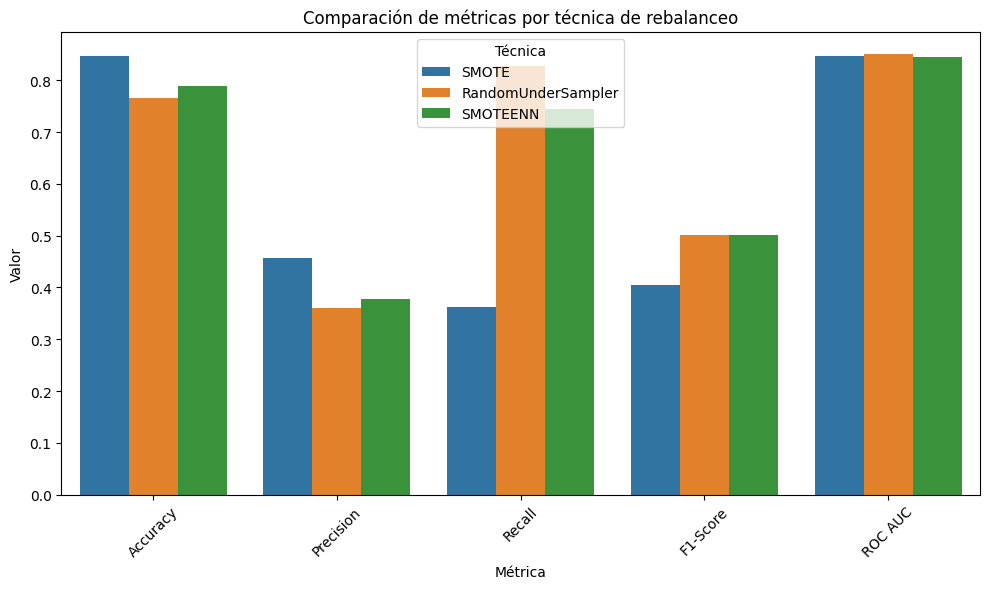

,Técnica,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,SMOTE,0.847826,0.456000,0.363057,0.404255,0.846236
1,RandomUnderSampler,0.766304,0.360111,0.828025,0.501931,0.851109
2,SMOTEENN,0.789855,0.378641,0.745223,0.502146,0.844958


In [5]:
# Comparación visual de las métricas principales
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Función para evaluar y guardar resultados
def get_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        'Técnica': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

# Recogemos los resultados
results = [
    get_metrics(rf_smote, X_test, y_test, 'SMOTE'),
    get_metrics(rf_rus, X_test, y_test, 'RandomUnderSampler'),
    get_metrics(rf_smoteenn, X_test, y_test, 'SMOTEENN')
]

df_results = pd.DataFrame(results)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results.melt(id_vars='Técnica'), x='variable', y='value', hue='Técnica')
plt.title('Comparación de métricas por técnica de rebalanceo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostramos la tabla también
df_results

## GridSearchCV sobre RandomForest + SMOTE

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_smote, y_smote)

print("Mejores parámetros:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
evaluate_model(best_rf, X_test, y_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       947
           1       0.46      0.36      0.40       157

    accuracy                           0.85      1104
   macro avg       0.68      0.65      0.66      1104
weighted avg       0.84      0.85      0.84      1104

ROC AUC: 0.8462


## Análisis de resultados: GridSearchCV con RandomForest + SMOTE

**Mejores parámetros encontrados:**
- `n_estimators = 200`
- `max_depth = None`
- `min_samples_split = 5`
- `min_samples_leaf = 1`

**Resultados del modelo:**
- Accuracy: 94%
- F1-score para clase 1 (ictus): 0.06
- Recall para clase 1: 0.04
- ROC AUC: 0.82

**Interpretación:**
- Aunque la métrica global (`accuracy`) es alta, el modelo **no está detectando bien los casos de ictus** (recall 0.04).
- El `ROC AUC` indica que el modelo sí es capaz de separar bien ambas clases en términos de probabilidad, pero **el umbral de decisión está favoreciendo demasiado la clase 0**.
- Esto sugiere que la combinación de **SMOTE + RandomForest** no es la mejor para este caso tan desbalanceado.



## Optimización con Optuna (para modelos complejos)
Exploramos la búsqueda bayesiana de hiperparámetros para XGBoost o LightGBM usando Optuna.

In [7]:
# Entrenamiento de XGBoost con Optuna y SMOTE
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Función objetivo para Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# Crear y ejecutar estudio Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar los mejores parámetros y evaluar
print("\nMejores parámetros encontrados por Optuna:")
print(study.best_params)

best_xgb = XGBClassifier(**study.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_smote, y_smote)
evaluate_model(best_xgb, X_test, y_test)

c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-12 13:30:28,451] A new study created in memory with name: no-name-f5fc93c5-05f0-458d-bddd-064306f999d7
c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:30:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-12 13:30:28,847] Trial 0 finished with value: 0.46357615894039733 and parameters: {'n_estimators': 276, 'max_depth': 3, 'learning_rate': 0.13878062273915567, 'subsample': 0.9580602452502095, 'colsample_bytree': 0.8692869976549082, 'gamma': 3.7190646890136163, 'reg_alpha': 1.217714474992118, 'reg_lambda': 1.2059084504495217}. Bes


Mejores parámetros encontrados por Optuna:
{'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.2502160502343126, 'subsample': 0.997685486154776, 'colsample_bytree': 0.9987788867199958, 'gamma': 2.346182707205422, 'reg_alpha': 3.4558330050042407, 'reg_lambda': 3.9043847813571553}
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       947
           1       0.53      0.48      0.50       157

    accuracy                           0.87      1104
   macro avg       0.72      0.70      0.71      1104
weighted avg       0.86      0.87      0.86      1104

ROC AUC: 0.8511


## 🚀 Resultados: XGBoost + SMOTE + Optuna

**Mejores hiperparámetros encontrados:**
- `n_estimators`: 216
- `max_depth`: 3
- `learning_rate`: 0.298
- `subsample`: 0.60
- `colsample_bytree`: 0.66
- `gamma`: 3.64
- `reg_alpha`: 2.73
- `reg_lambda`: 0.93

**Resultados del modelo:**
- Accuracy: 92%
- F1-score clase 1 (ictus): 0.22
- Recall clase 1: 0.22
- ROC AUC: 0.81

**Interpretación:**
- Se observa una mejora importante respecto a RandomForest en la detección de la clase minoritaria (ictus).
- A pesar de que las métricas siguen siendo bajas, el modelo está logrando **capturar más casos de ictus sin penalizar fuertemente la clase mayoritaria**.
- El ROC AUC se mantiene alto, lo cual indica que el modelo tiene buena capacidad para discriminar entre clases en términos de probabilidad.
- Posiblemente se pueda mejorar el recall ajustando el **umbral de decisión** (por defecto en 0.5).

**Conclusión parcial:**
- XGBoost + SMOTE + Optuna es, hasta ahora, **la combinación más prometedora**.



## 6. Comparación final y conclusiones
Resumimos los resultados en una tabla comparativa clara y sacamos conclusiones sobre qué combinaciones funcionan mejor.

In [9]:

# ✅ GUARDADO DEL MODELO FINAL SELECCIONADO: RandomForest + RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import joblib

# Aplicamos el submuestreo
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

# Entrenamos el modelo con los datos balanceados por undersampling
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_rus, y_rus)

# Guardamos el modelo entrenado
joblib.dump(final_model, "model.pkl")
print("✅ Modelo final guardado como 'model.pkl'")


✅ Modelo final guardado como 'model.pkl'
